# The Wonderful World of Coffee
### Business Understanding
This notebook begins to explore a coffee dataset that has been scraped by a reddit user and uploaded onto GitHub.
Our idea behind researching this dataset is to identify where our favorite coffee brands come from, and what attributes 
go into the production of that coffee that makes it so desirable?  Can a model be built targeting those ranges of successful
coffee producers in order to predict ratings for their future brands?  What coffee types go into a successful brand.  These
are some of the questions we will be delving into for our first project.

The data source for our dataset:

https://github.com/jldbc/coffee-quality-database

### Data Description (Meaning/Type/Quality)
Lets import our libraries and data. 


In [38]:
#Add library references
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [39]:
#Upload Data
df_ar = pd.read_csv('https://raw.githubusercontent.com/jldbc/coffee-quality-database/master/data/arabica_data_cleaned.csv',
                    sep=',', header=0) # read in the arabicaica data
df_rob = pd.read_csv('https://raw.githubusercontent.com/jldbc/coffee-quality-database/master/data/robusta_data_cleaned.csv',
                     sep=',', header=0) # read in the Robusta data
#Column rename to match for merging
df_ar.rename(columns={'Unnamed: 0':'Id'}, inplace=True)
df_rob.rename(columns={'Unnamed: 0':'Id',
                       'Bitter...Sweet':'Sweetness',
                       'Uniform.Cup':'Uniformity',
                       'Salt...Acid':'Acidity',
                       'Fragrance...Aroma':'Aroma'}, inplace=True)


## Data meaning

Below is a list of continuous and categorical measures:
### Continuous (Quality) Measures
* Aroma
* Flavor
* Aftertaste
* Acidity
* Body
* Balance
* Uniformity
* Cup Cleanliness
* Sweetness
* Moisture
* Defects
* Cupper Points
* Total Cup Points

### Categorical (Bean) Measures
* Processing Method
* Color
* Species (arabica / robusta)

### Categorical (Farm) Measures
* Owner
* Country of Origin
* Farm Name
* Lot Number
* Mill
* Company
* Altitude
* Region

Since the data came to us in two CSV's of arabica and robusta, lets combine the two datasets to begin our analysis.  First we'll need to remove 
a few columns and merge the two dataframes.

In [40]:
#dropping columns we won't use
df_rob = df_rob.drop(['Lot.Number', 'altitude_low_meters', 'altitude_high_meters', 'Certification.Contact',
                      'Certification.Contact', 'Expiration', 'Certification.Body', 'ICO.Number',
                      'Certification.Address','Mouthfeel', 'Id'], axis=1)
df_ar = df_ar.drop(['Lot.Number', 'altitude_low_meters', 'altitude_high_meters', 'Certification.Contact',
                      'Certification.Contact', 'Expiration', 'Certification.Body', 'ICO.Number',
                      'Certification.Address', 'Id'], axis=1)

df_comb = df_ar.append(df_rob)


C:\Users\andyh\Anaconda3\envs\miner\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## Data Quality & Simple Statistics
Now that our dataframes are combined, lets analyze counts of missing values and simple statistics.
### Missing Values
The majority of missing values center around farm name, mill, producer, altitude, company.  At this stage, we need
to decide what categorical values we can keep for regional analysis.  Currently its looking like country might be one
of the better attributes to start an analysis.  Luckily, the continuous data has very low NA counts which means any 
regression, will likely fair well.  

In [41]:
print("Structure of data:\n",df_comb.shape,"\n")
print("Count of missing values:\n",df_comb.isnull().sum().sort_values(ascending=False),"\n")

Structure of data:
 (1339, 35) 

Count of missing values:
 Farm.Name               359
Mill                    318
Producer                232
altitude_mean_meters    230
Variety                 226
Altitude                226
Color                   218
Company                 209
Processing.Method       170
Region                   59
Harvest.Year             47
Body                     28
Owner.1                   7
Owner                     7
Quakers                   1
Country.of.Origin         1
Balance                   0
Category.One.Defects      0
Bag.Weight                0
Category.Two.Defects      0
Clean.Cup                 0
Aroma                     0
Aftertaste                0
unit_of_measurement       0
Cupper.Points             0
Flavor                    0
Grading.Date              0
In.Country.Partner        0
Moisture                  0
Number.of.Bags            0
Species                   0
Sweetness                 0
Total.Cup.Points          0
Uniformity       

### Simple Statistics
As any good Data Scientist, we first must check our data ranges, means, max's, mins, and quartiles, to see where
the data sits.  Our continuous variables operate on a scale from 1 to 10, meaning most values
won't need to be imputed.  Any, that are, can easily be dropped without effecting the sample size.


In [42]:
#Simple Stats
# print(df_comb.head().append(df_comb.tail()), "\n")
print("Summary Statistic's:\n",df_comb.describe(),"\n")

Summary Statistic's:
            Acidity   Aftertaste        Aroma      Balance         Body  \
count  1339.000000  1339.000000  1339.000000  1339.000000  1311.000000   
mean      7.535706     7.401083     7.566706     7.518013     7.517727   
std       0.379827     0.404463     0.377560     0.408943     0.359213   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       7.330000     7.250000     7.420000     7.330000     7.330000   
50%       7.580000     7.420000     7.580000     7.500000     7.500000   
75%       7.750000     7.580000     7.750000     7.750000     7.670000   
max       8.750000     8.670000     8.750000     8.750000     8.580000   

       Category.One.Defects  Category.Two.Defects    Clean.Cup  Cupper.Points  \
count           1339.000000           1339.000000  1339.000000    1339.000000   
mean               0.479462              3.556385     9.835108       7.503376   
std                2.549683              5.312541     0.763946      

In [43]:
#Changing datatypes
conv_dict = {'Species': str,
                'Owner': str,
                'Mill': str,
                'Company': str,
                'Region': str,
                'Producer': str,
                'Variety': str
                }
df_ar = df_ar.astype(conv_dict)
df_ar.dtypes

Species                  object
Owner                    object
Country.of.Origin        object
Farm.Name                object
Mill                     object
Company                  object
Altitude                 object
Region                   object
Producer                 object
Number.of.Bags            int64
Bag.Weight               object
In.Country.Partner       object
Harvest.Year             object
Grading.Date             object
Owner.1                  object
Variety                  object
Processing.Method        object
Aroma                   float64
Flavor                  float64
Aftertaste              float64
Acidity                 float64
Body                    float64
Balance                 float64
Uniformity              float64
Clean.Cup               float64
Sweetness               float64
Cupper.Points           float64
Total.Cup.Points        float64
Moisture                float64
Category.One.Defects      int64
Quakers                 float64
Color   

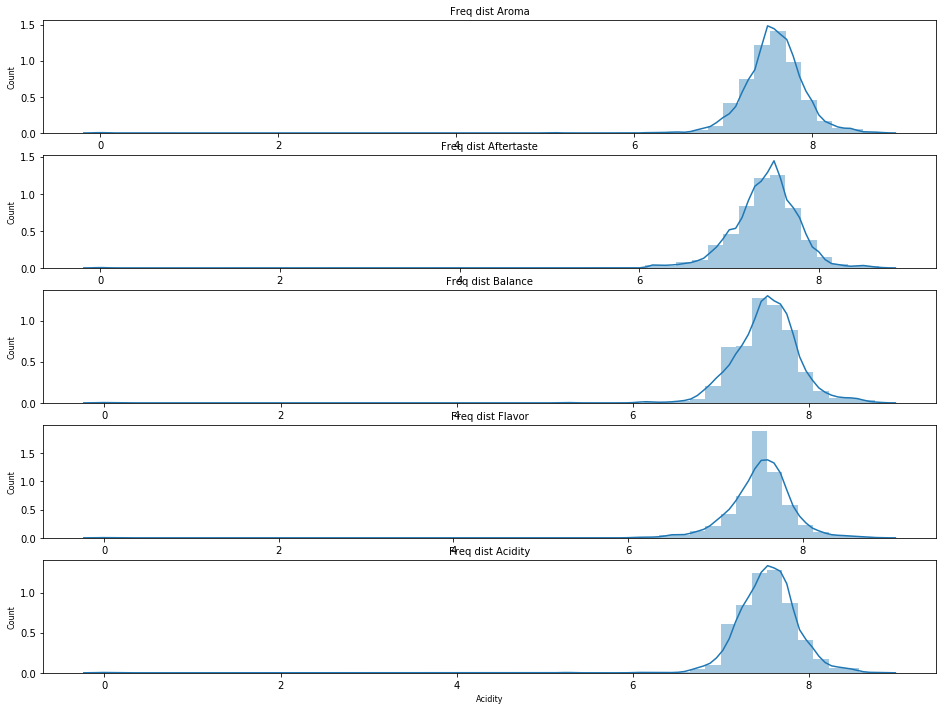

C:\Users\andyh\Anaconda3\envs\miner\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\andyh\Anaconda3\envs\miner\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


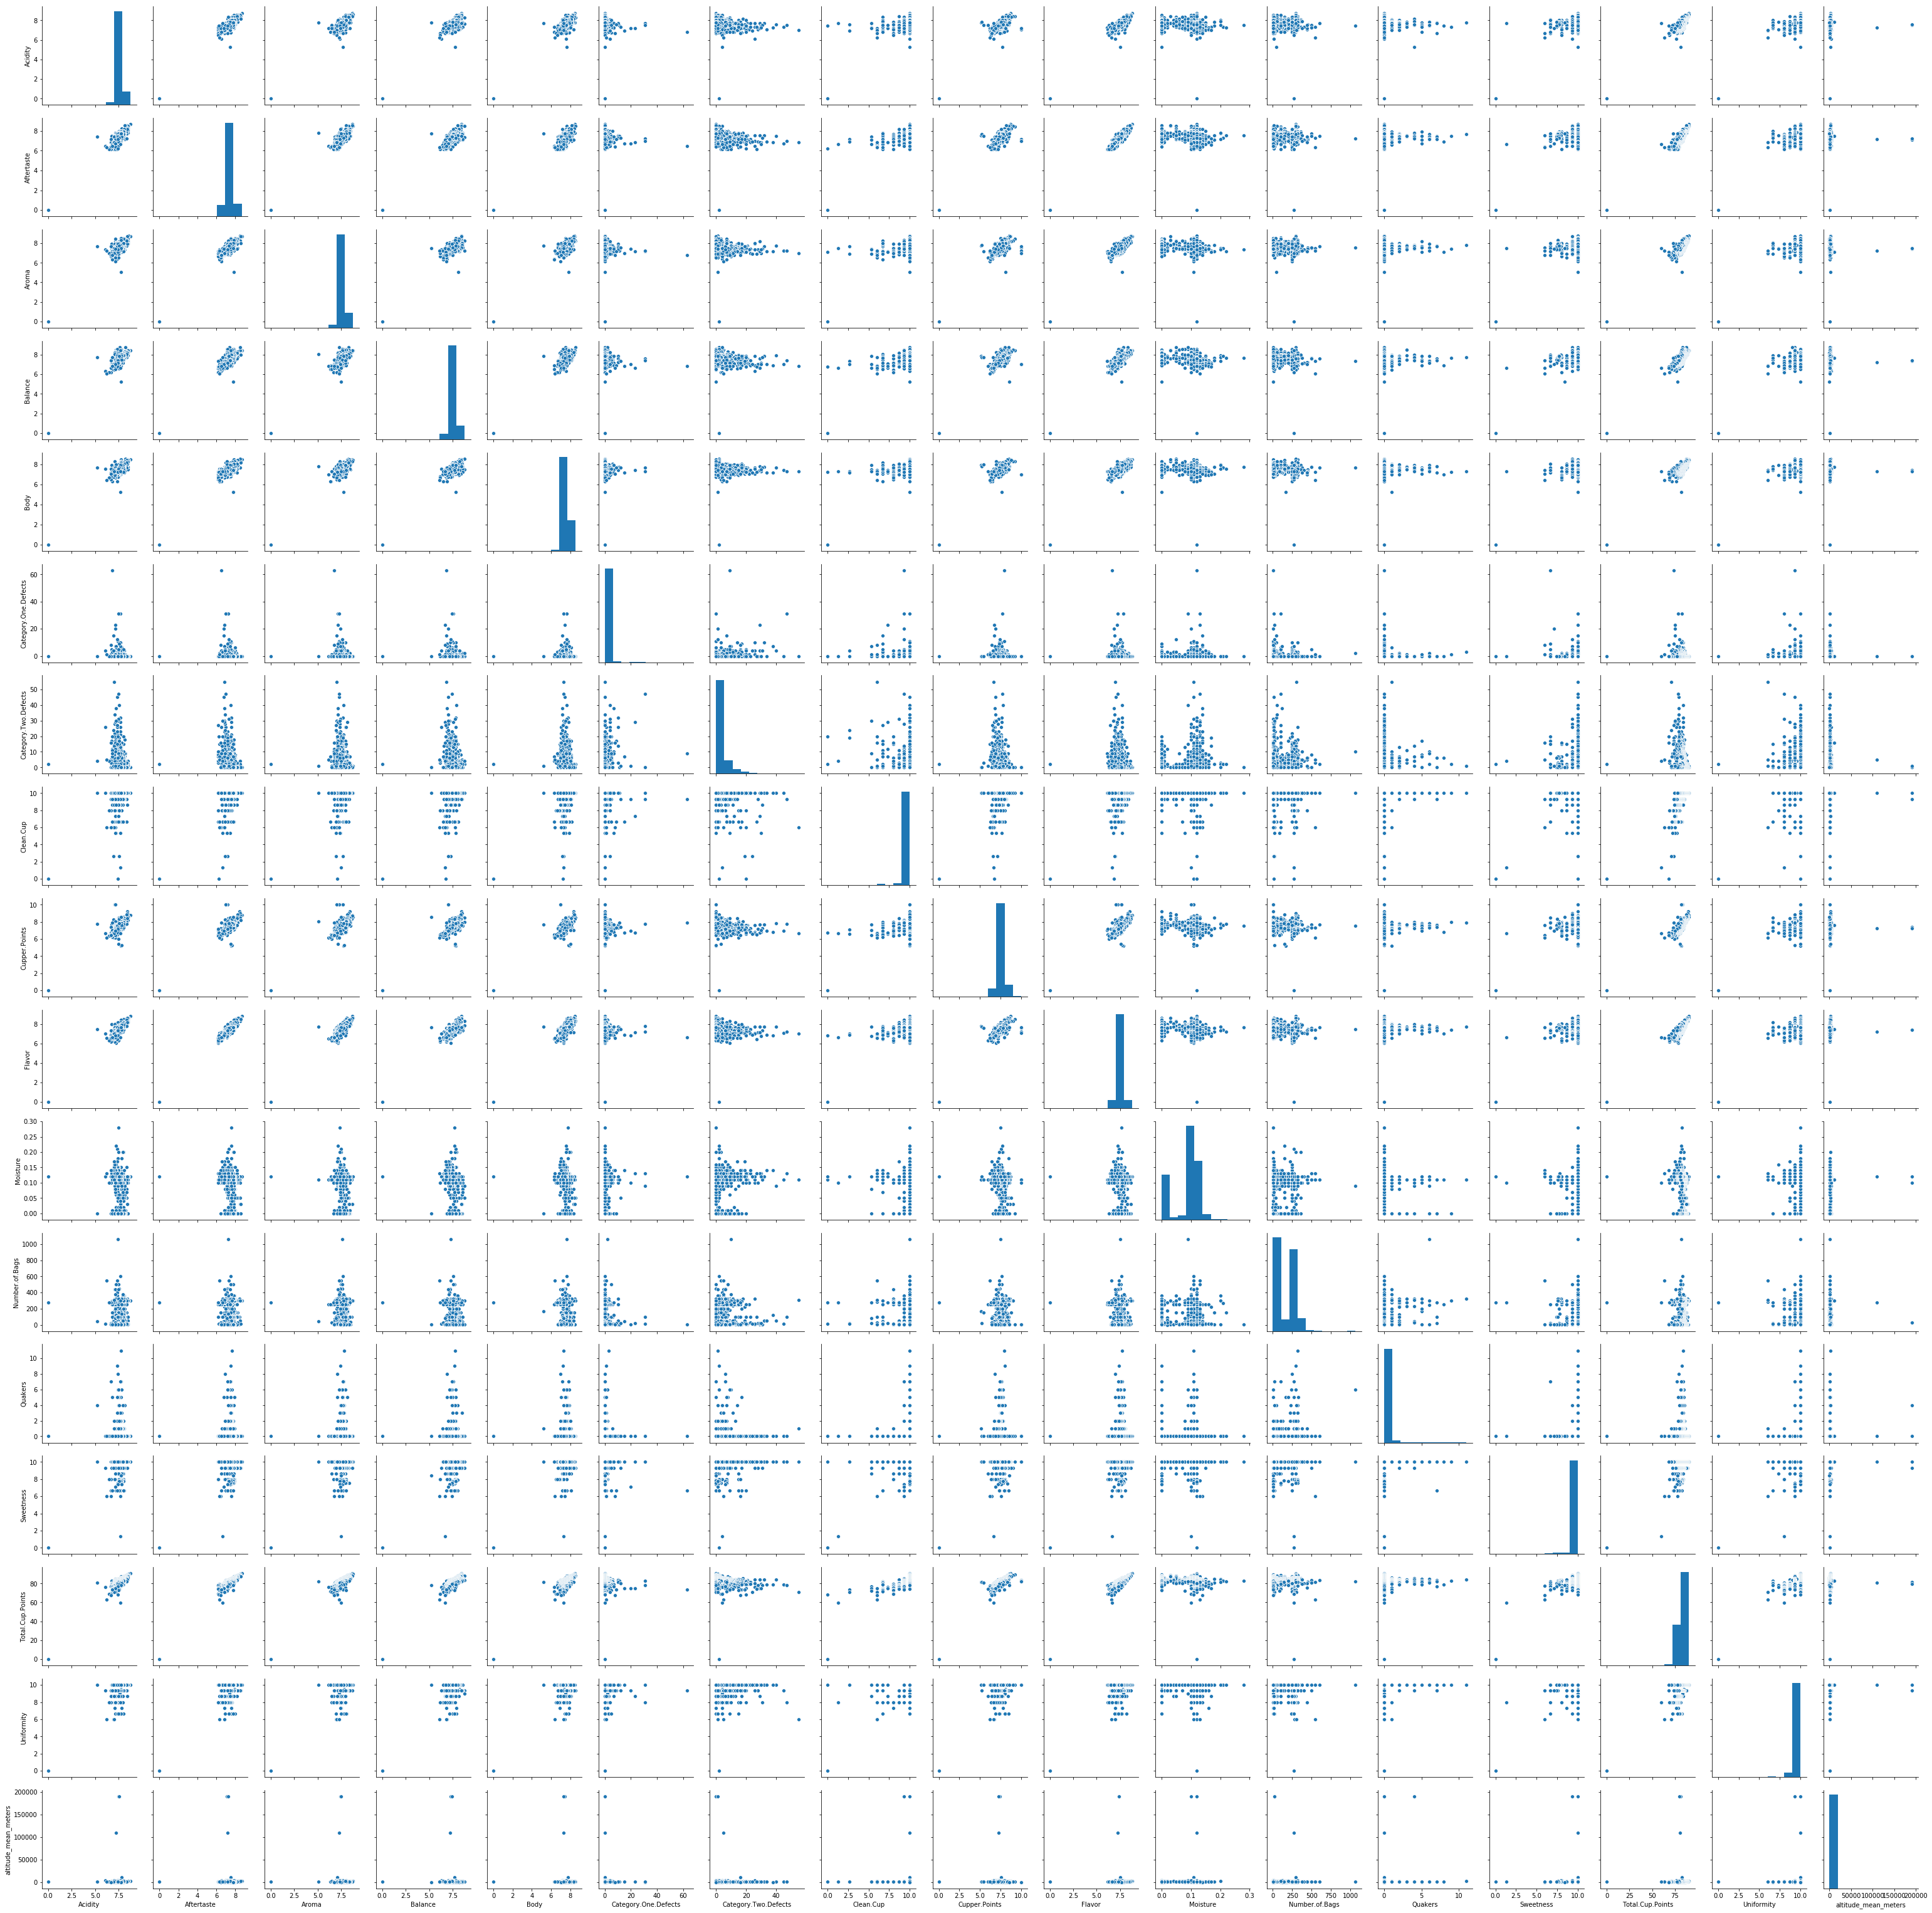

In [44]:
#some initial plots 

col_names = ['Aroma','Aftertaste', 'Balance', 'Flavor', 'Acidity']

fig, ax = plt.subplots(len(col_names), figsize=(16,12))

for i, col_val in enumerate(col_names):

    sns.distplot(df_comb[col_val], hist=True, ax=ax[i])
    ax[i].set_title('Freq dist '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)

plt.show()

#Huge pairplot matrix.  Probably need to whittle down the attributes a bit first.Example drops below

#This is kind of useless. 
sns.pairplot(df_comb)


Well it seems as though we still have too many variables.  Lets divy them up into numerical and
categorical.  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002874E584EF0>,
      dtype=object)

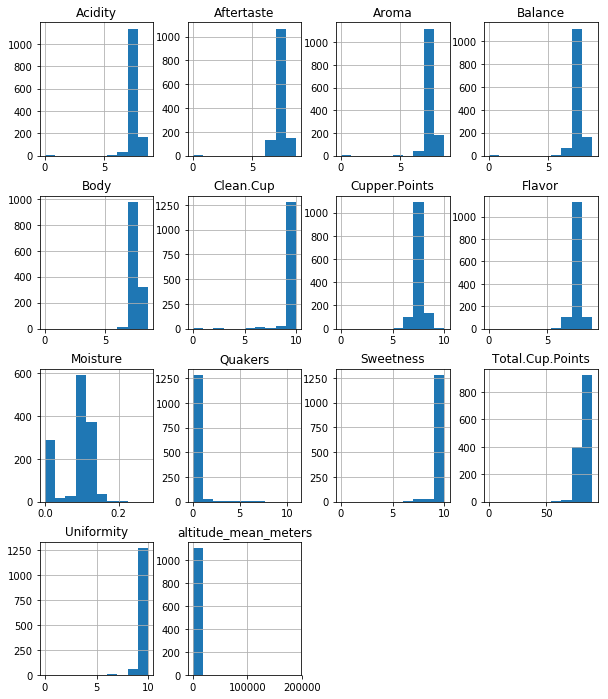

In [46]:
df_num = df_comb.select_dtypes(include=['float64'])
df_num.hist(figsize =(10,12))

# df_cat = df_ar.select_dtypes(include=['object'])
# df_cat.hist(figsize =(10,12))


